# Rainfall Forecasting & Trend Analysis in Delhi NCR

## Project Overview

This project leverages satellite-derived monthly rainfall data to analyze, visualize, and predict rainfall patterns in Delhi NCR over a decade. Aimed at supporting water resource management, agriculture, and urban planning, the work offers scientifically-backed insights and forecasts.

## Data Source & Methodology

- **Data Source:** NASA GPM IMERG Monthly Satellite Data (mm/month, converted from mm/hr)
  ```
  NASA/GPM_L3/IMERG_MONTHLY_V07
  ```
- **Tools & Libraries:** Python, Pandas, NumPy, Matplotlib, Scikit-learn, XGBoost, TensorFlow Keras
- **Approach:** Spatial-temporal analysis, Mann-Kendall trend detection, feature engineering, multi-model forecasting

## Data Processing

Raw IMERG data (mm/hr) is converted to monthly accumulation (mm/month) using hour-in-month multipliers based on calendar days. All statistical analyses use the corrected monthly accumulation values.


In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow import keras
from scipy import stats
import warnings
import os
import calendar
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

results_dir = 'results'
data_dir = 'data'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created {results_dir} folder")

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Created {data_dir} folder")

/home/ansh/miniconda3/envs/ML/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## 1. Data Extraction from Google Earth Engine (with Caching)

In [2]:
cached_data_path = os.path.join(data_dir, 'rainfall_df_cached.pkl')

if os.path.exists(cached_data_path):
    print(f"Loading cached data from {cached_data_path}...")
    rainfall_df = pd.read_pickle(cached_data_path)
    print(f"Cached data loaded: {len(rainfall_df)} records")
else:
    print("No cached data found. Extracting from Earth Engine...")
    
    ee.Authenticate()
    ee.Initialize()

    delhi_ncr = ee.Geometry.Rectangle([76.5, 28.0, 78.5, 29.5])

    dataset = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V07').filterDate('2004-01-01', '2024-01-01').filterBounds(delhi_ncr)

    print(f'Number of images: {dataset.size().getInfo()}')
    
    import calendar

    def get_hours_in_month(year, month):
        days = calendar.monthrange(year, month)[1]
        return days * 24

    def extract_rainfall_data(image_collection, geometry):
        rainfall_data = []
        total_images = image_collection.size().getInfo()
        
        for i in range(total_images):
            image = ee.Image(image_collection.toList(total_images).get(i))
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM').getInfo()
            year = int(date.split('-')[0])
            month = int(date.split('-')[1])
            
            precipitation_mmhr = image.select('precipitation').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=1000
            ).getInfo()['precipitation']
            
            hours = get_hours_in_month(year, month)
            precipitation_mmmonth = precipitation_mmhr * hours if precipitation_mmhr is not None else None
            
            rainfall_data.append({
                'date': date,
                'year': year,
                'month': month,
                'precipitation_mmhr': precipitation_mmhr,
                'precipitation_mmmonth': precipitation_mmmonth,
                'hours_in_month': hours
            })
            
            if (i + 1) % 10 == 0 or (i + 1) == total_images:
                print(f"Processed {i + 1} of {total_images}: {date}")
        
        return pd.DataFrame(rainfall_data)

    rainfall_df = extract_rainfall_data(dataset, delhi_ncr)
    
    rainfall_df.to_pickle(cached_data_path)
    print(f"\nData cached to {cached_data_path}")

rainfall_df.head(12)

Loading cached data from data/rainfall_df_cached.pkl...
Cached data loaded: 240 records


,date,year,month,precipitation_mmhr,precipitation_mmmonth,hours_in_month
0,2004-01,2004,1,0.047939,35.666261,744
1,2004-02,2004,2,0.002008,1.397798,696
2,2004-03,2004,3,0.003213,2.390530,744
3,2004-04,2004,4,0.087500,62.999923,720
4,2004-05,2004,5,0.045625,33.945043,744
5,2004-06,2004,6,0.104536,75.265590,720
6,2004-07,2004,7,0.117827,87.663204,744
7,2004-08,2004,8,0.394046,293.170039,744
8,2004-09,2004,9,0.041141,29.621821,720
9,2004-10,2004,10,0.118977,88.518555,744


In [3]:
rainfall_df['month_name'] = rainfall_df['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

print('Data Summary:')
print(f'Total records: {len(rainfall_df)}')
print(f'Date range: {rainfall_df["date"].min()} to {rainfall_df["date"].max()}')
print(f'Missing values: {rainfall_df["precipitation_mmmonth"].isna().sum()}')
print(f'\nMonthly precipitation statistics (mm/month):')
print(rainfall_df['precipitation_mmmonth'].describe())

rainfall_df.to_csv(os.path.join(results_dir, 'rainfall_data_raw.csv'), index=False)
rainfall_df.to_pickle(os.path.join(data_dir, 'rainfall_df_processed.pkl'))
print(f"\nRaw data saved to {results_dir}/rainfall_data_raw.csv")
print(f"Processed data saved to {data_dir}/rainfall_df_processed.pkl")

Data Summary:
Total records: 240
Date range: 2004-01 to 2023-12
Missing values: 0

Monthly precipitation statistics (mm/month):
count    240.000000
mean      65.734405
std       84.137007
min        0.000000
25%        5.858817
50%       28.061516
75%       95.797737
max      336.115087
Name: precipitation_mmmonth, dtype: float64

Raw data saved to results/rainfall_data_raw.csv
Processed data saved to data/rainfall_df_processed.pkl


## 2. Exploratory Data Analysis

Saved: results/01_exploratory_analysis.png


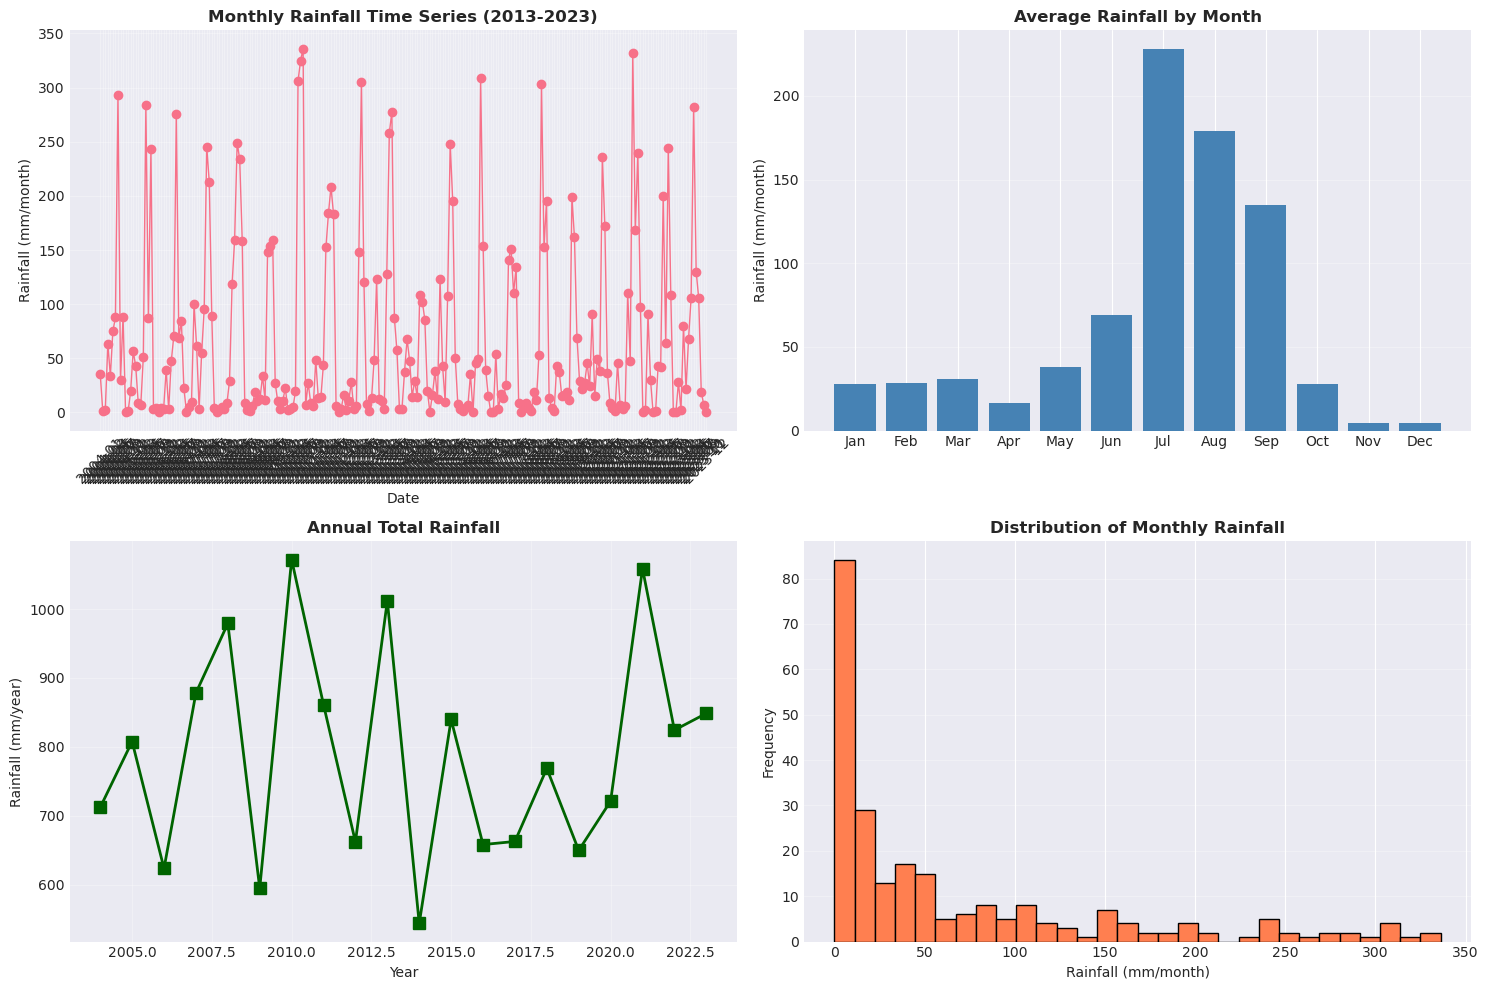


Annual Rainfall Summary:
year
2004     712.069492
2005     807.681389
2006     623.367495
2007     878.122204
2008     978.976615
2009     594.506007
2010    1071.817307
2011     861.101298
2012     661.933343
2013    1011.990296
2014     543.670230
2015     839.645172
2016     658.077674
2017     662.591315
2018     768.610221
2019     649.632309
2020     721.145630
2021    1058.613536
2022     824.202743
2023     848.502883
Name: precipitation_mmmonth, dtype: float64

Mean annual rainfall: 788.81 mm
Std deviation: 156.34 mm


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(rainfall_df['date'], rainfall_df['precipitation_mmmonth'], marker='o', linestyle='-', linewidth=1)
axes[0, 0].set_title('Monthly Rainfall Time Series (2013-2023)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Rainfall (mm/month)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

month_avg = rainfall_df.groupby('month_name')['precipitation_mmmonth'].mean().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)
axes[0, 1].bar(range(12), month_avg.values, color='steelblue')
axes[0, 1].set_xticks(range(12))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0, 1].set_title('Average Rainfall by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Rainfall (mm/month)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

annual_rainfall = rainfall_df.groupby('year')['precipitation_mmmonth'].sum()
axes[1, 0].plot(annual_rainfall.index, annual_rainfall.values, marker='s', linestyle='-', linewidth=2, markersize=8, color='darkgreen')
axes[1, 0].set_title('Annual Total Rainfall', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Rainfall (mm/year)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(rainfall_df['precipitation_mmmonth'].dropna(), bins=30, color='coral', edgecolor='black')
axes[1, 1].set_title('Distribution of Monthly Rainfall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Rainfall (mm/month)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '01_exploratory_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {results_dir}/01_exploratory_analysis.png")
plt.show()

print('\nAnnual Rainfall Summary:')
print(annual_rainfall)
print(f'\nMean annual rainfall: {annual_rainfall.mean():.2f} mm')
print(f'Std deviation: {annual_rainfall.std():.2f} mm')

## 3. Mann-Kendall Trend Analysis

In [5]:
def mann_kendall_test(data):
    n = len(data)
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(data.iloc[j] - data.iloc[i])
    
    var_s = n * (n - 1) * (2 * n + 5) / 18
    z = (s - np.sign(s)) / np.sqrt(var_s) if var_s > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value, s

def sen_slope(data):
    n = len(data)
    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            slopes.append((data.iloc[j] - data.iloc[i]) / (j - i))
    return np.median(slopes)

annual_rainfall_series = rainfall_df.groupby('year')['precipitation_mmmonth'].sum()
z_annual, p_annual, s_annual = mann_kendall_test(annual_rainfall_series)
slope_annual = sen_slope(annual_rainfall_series)

print('ANNUAL MANN-KENDALL TEST')
print(f'Z-statistic: {z_annual:.4f}')
print(f'P-value: {p_annual:.4f}')
print(f'S-statistic: {s_annual:.0f}')
print(f'Sen\'s Slope: {slope_annual:.4f} mm/year')
print(f'Significant trend (α=0.05): {"Yes" if p_annual < 0.05 else "No"}')
print(f'Sample size: {len(annual_rainfall_series)} years')

ANNUAL MANN-KENDALL TEST
Z-statistic: 0.2920
P-value: 0.7703
S-statistic: 10
Sen's Slope: 2.1441 mm/year
Significant trend (α=0.05): No
Sample size: 20 years


## 4. Month-wise Trend Analysis with Bonferroni Correction

In [6]:
bonferroni_alpha = 0.05 / 12

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

trend_results = []

for month in month_order:
    month_data = rainfall_df[rainfall_df['month_name'] == month]['precipitation_mmmonth'].reset_index(drop=True)
    
    z, p_value, s = mann_kendall_test(month_data)
    slope = sen_slope(month_data)
    
    x = np.arange(len(month_data))
    slope_linreg, intercept, r_value, p_linreg, std_err = stats.linregress(x, month_data)
    
    cv = (month_data.std() / month_data.mean() * 100) if month_data.mean() != 0 else 0
    
    trend_results.append({
        'Month': month,
        'Slope (mm/year)': slope,
        'Z-statistic': z,
        'P-value': p_value,
        'Significant (α=0.05)': 'Yes' if p_value < 0.05 else 'No',
        'Significant (Bonferroni α=0.0042)': 'Yes' if p_value < bonferroni_alpha else 'No',
        'CV (%)': cv,
        'Mean (mm)': month_data.mean(),
        'Std Dev': month_data.std()
    })

trend_df = pd.DataFrame(trend_results)
print('MONTH-WISE TREND ANALYSIS (with Bonferroni Correction)')
print(f'Bonferroni-corrected α: {bonferroni_alpha:.4f}')
print()
print(trend_df.to_string(index=False))

trend_df.to_csv(os.path.join(results_dir, 'trend_analysis_monthly.csv'), index=False)
trend_df.to_pickle(os.path.join(data_dir, 'trend_df.pkl'))
print(f"\nTrend analysis saved to {results_dir}/trend_analysis_monthly.csv")
print(f"Trend DataFrame cached to {data_dir}/trend_df.pkl")

MONTH-WISE TREND ANALYSIS (with Bonferroni Correction)
Bonferroni-corrected α: 0.0042

    Month  Slope (mm/year)  Z-statistic  P-value Significant (α=0.05) Significant (Bonferroni α=0.0042)     CV (%)  Mean (mm)   Std Dev
  January         1.688102     2.433321 0.014961                  Yes                                No  82.529994  27.787886 22.933341
 February        -0.050488    -0.227110 0.820338                   No                                No 120.670627  28.719423 34.655908
    March         0.220807     0.097333 0.922462                   No                                No 111.585457  30.828740 34.400390
    April         0.093105     0.032444 0.974118                   No                                No  94.736038  16.242672 15.387664
      May         0.847234     0.681330 0.495663                   No                                No  85.006063  38.081199 32.371328
     June        -1.313295    -0.551553 0.581255                   No                            

In [7]:
significant_months = trend_df[trend_df['Significant (Bonferroni α=0.0042)'] == 'Yes']
print('\nSIGNIFICANT TRENDS (Bonferroni-corrected, p < 0.0042):')
if len(significant_months) > 0:
    for idx, row in significant_months.iterrows():
        print(f"  {row['Month']}: Slope = {row['Slope (mm/year)']:.4f} mm/year, p-value = {row['P-value']:.6f}")
else:
    print('  No months show statistically significant trends after Bonferroni correction.')

print('\nNEAR-SIGNIFICANT TRENDS (0.0042 < p < 0.05):')
near_sig = trend_df[(trend_df['P-value'] >= bonferroni_alpha) & (trend_df['P-value'] < 0.05)]
if len(near_sig) > 0:
    for idx, row in near_sig.iterrows():
        print(f"  {row['Month']}: Slope = {row['Slope (mm/year)']:.4f} mm/year, p-value = {row['P-value']:.6f}")
else:
    print('  No near-significant trends found.')


SIGNIFICANT TRENDS (Bonferroni-corrected, p < 0.0042):
  No months show statistically significant trends after Bonferroni correction.

NEAR-SIGNIFICANT TRENDS (0.0042 < p < 0.05):
  January: Slope = 1.6881 mm/year, p-value = 0.014961


## 5. Seasonal Analysis

Seasonal data cached to data/seasonal_data.pkl


Saved: results/02_seasonal_trends.png


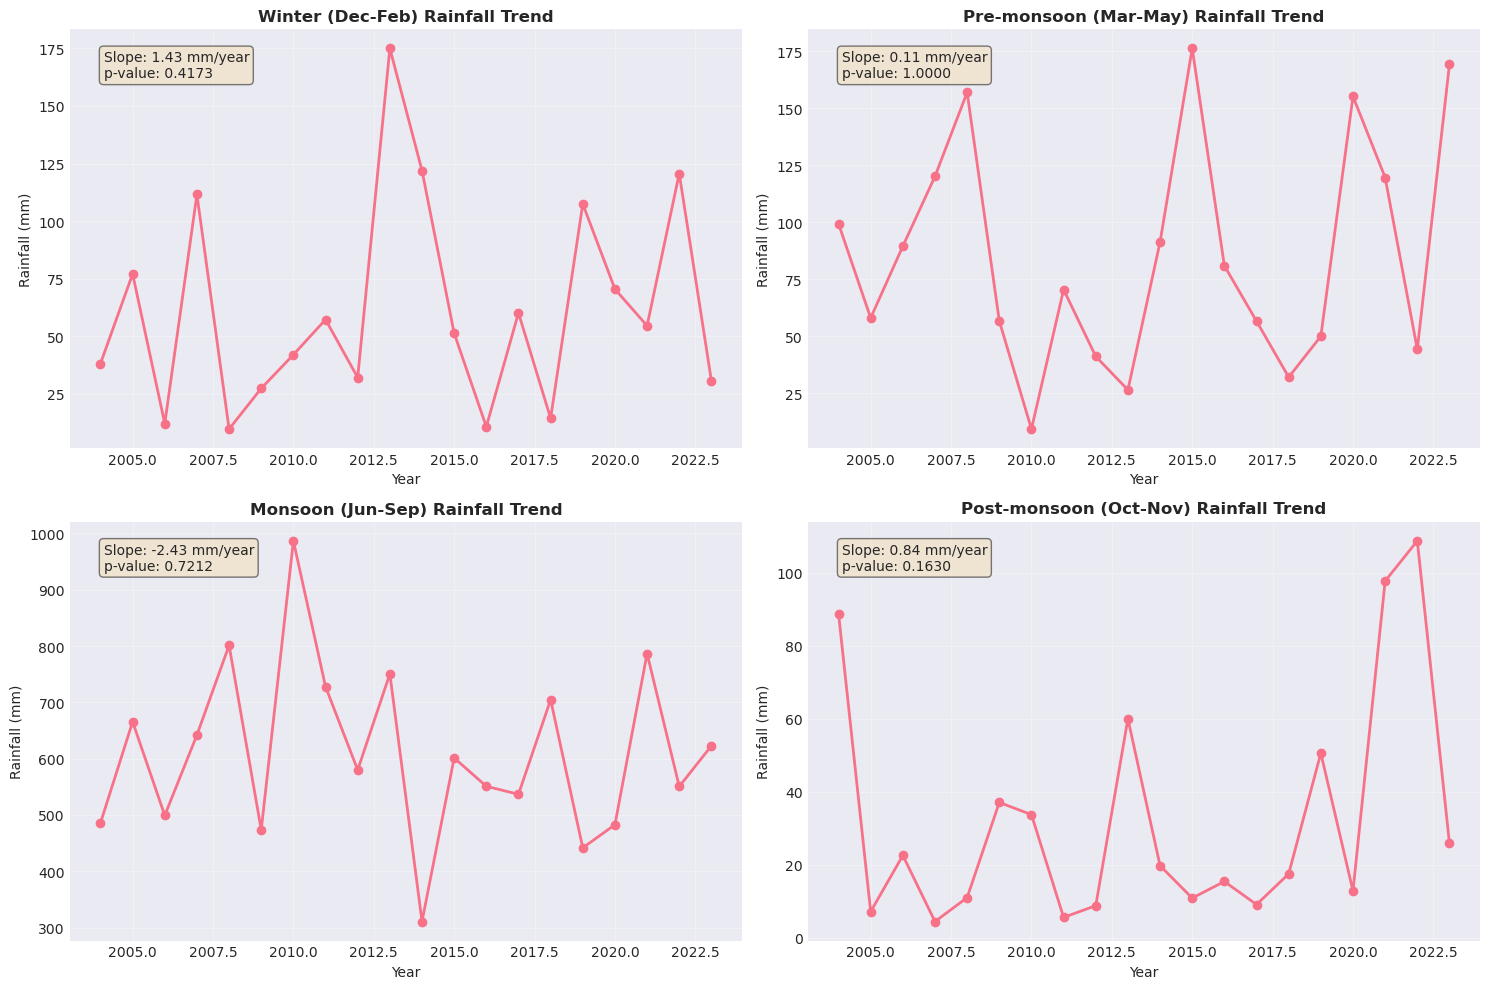

In [8]:
def categorize_season(month):
    if month in [6, 7, 8, 9]:
        return 'Monsoon (Jun-Sep)'
    elif month in [3, 4, 5]:
        return 'Pre-monsoon (Mar-May)'
    elif month in [10, 11]:
        return 'Post-monsoon (Oct-Nov)'
    else:
        return 'Winter (Dec-Feb)'

rainfall_df['season'] = rainfall_df['month'].apply(categorize_season)

seasonal_data = rainfall_df.groupby(['year', 'season'])['precipitation_mmmonth'].sum().reset_index()
seasonal_data.to_pickle(os.path.join(data_dir, 'seasonal_data.pkl'))
print(f"Seasonal data cached to {data_dir}/seasonal_data.pkl")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

seasons = ['Winter (Dec-Feb)', 'Pre-monsoon (Mar-May)', 'Monsoon (Jun-Sep)', 'Post-monsoon (Oct-Nov)']

for idx, (ax, season) in enumerate(zip(axes.flat, seasons)):
    season_data = seasonal_data[seasonal_data['season'] == season].sort_values('year')
    ax.plot(season_data['year'], season_data['precipitation_mmmonth'], marker='o', linestyle='-', linewidth=2)
    ax.set_title(f'{season} Rainfall Trend', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Rainfall (mm)')
    ax.grid(True, alpha=0.3)
    
    z, p, s = mann_kendall_test(season_data['precipitation_mmmonth'].reset_index(drop=True))
    slope = sen_slope(season_data['precipitation_mmmonth'].reset_index(drop=True))
    ax.text(0.05, 0.95, f'Slope: {slope:.2f} mm/year\np-value: {p:.4f}', 
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '02_seasonal_trends.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {results_dir}/02_seasonal_trends.png")
plt.show()

## 6. Coefficient of Variation Analysis

In [9]:
cv_analysis = []

for month in month_order:
    month_data = rainfall_df[rainfall_df['month_name'] == month]['precipitation_mmmonth']
    cv = (month_data.std() / month_data.mean() * 100) if month_data.mean() != 0 else 0
    
    if cv < 20:
        variability = 'Low'
    elif cv < 30:
        variability = 'Moderate'
    else:
        variability = 'High'
    
    cv_analysis.append({
        'Month': month,
        'CV (%)': cv,
        'Variability': variability,
        'Mean (mm)': month_data.mean(),
        'Std Dev': month_data.std()
    })

cv_df = pd.DataFrame(cv_analysis)
print('INTER-ANNUAL VARIABILITY ANALYSIS')
print(cv_df.to_string(index=False))

cv_df.to_csv(os.path.join(results_dir, 'variability_analysis.csv'), index=False)
cv_df.to_pickle(os.path.join(data_dir, 'cv_df.pkl'))
print(f"\nVariability analysis saved to {results_dir}/variability_analysis.csv")
print(f"CV DataFrame cached to {data_dir}/cv_df.pkl")

INTER-ANNUAL VARIABILITY ANALYSIS
    Month     CV (%) Variability  Mean (mm)   Std Dev
  January  82.529994        High  27.787886 22.933341
 February 120.670627        High  28.719423 34.655908
    March 111.585457        High  30.828740 34.400390
    April  94.736038        High  16.242672 15.387664
      May  85.006063        High  38.081199 32.371328
     June  71.853884        High  68.884289 49.496037
     July  31.128427        High 227.811810 70.914233
   August  43.410117        High 178.782646 77.609755
September  62.530472        High 134.529892 84.122177
  October 117.385207        High  27.989189 32.855168
 November 165.537403        High   4.414353  7.307405
 December 143.567841        High   4.740759  6.806205

Variability analysis saved to results/variability_analysis.csv
CV DataFrame cached to data/cv_df.pkl


Saved: results/03_coefficient_variation.png


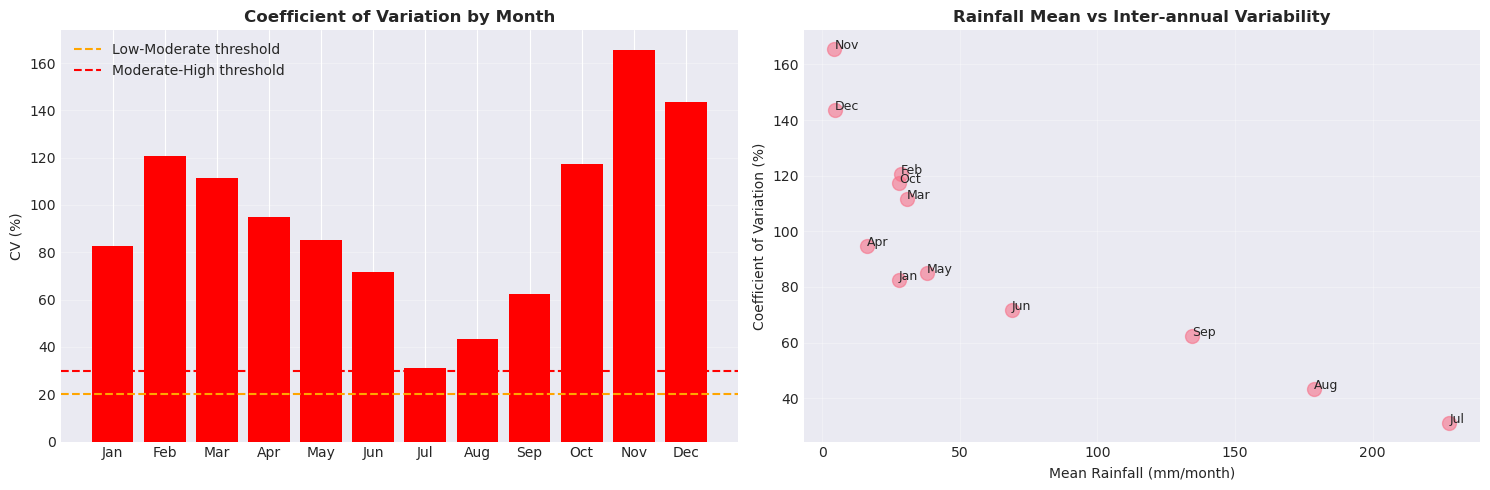

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors = ['green' if v == 'Low' else 'orange' if v == 'Moderate' else 'red' for v in cv_df['Variability']]
ax1.bar(range(12), cv_df['CV (%)'].values, color=colors)
ax1.set_xticks(range(12))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_title('Coefficient of Variation by Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('CV (%)')
ax1.axhline(y=20, color='orange', linestyle='--', label='Low-Moderate threshold')
ax1.axhline(y=30, color='red', linestyle='--', label='Moderate-High threshold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

ax2.scatter(cv_df['Mean (mm)'], cv_df['CV (%)'], s=100, alpha=0.6)
for i, month in enumerate(cv_df['Month']):
    ax2.annotate(month[:3], (cv_df['Mean (mm)'].iloc[i], cv_df['CV (%)'].iloc[i]), fontsize=9)
ax2.set_xlabel('Mean Rainfall (mm/month)')
ax2.set_ylabel('Coefficient of Variation (%)')
ax2.set_title('Rainfall Mean vs Inter-annual Variability', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '03_coefficient_variation.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {results_dir}/03_coefficient_variation.png")
plt.show()

## 7. Feature Engineering & ML Preparation (with Caching)

In [11]:
import pickle

ml_data_path = os.path.join(data_dir, 'ml_data.pkl')

if os.path.exists(ml_data_path):
    print(f"Loading cached ML data from {ml_data_path}...")
    with open(ml_data_path, 'rb') as f:
        ml_cache = pickle.load(f)
    X_train, y_train = ml_cache['X_train'], ml_cache['y_train']
    X_test, y_test = ml_cache['X_test'], ml_cache['y_test']
    print("Cached ML data loaded.")
else:
    print("Preparing ML data...")

    df_ml = rainfall_df[['year', 'month', 'precipitation_mmmonth']].sort_values(['year', 'month']).reset_index(drop=True)

    df_ml['lag_1'] = df_ml['precipitation_mmmonth'].shift(1)
    df_ml['lag_3'] = df_ml['precipitation_mmmonth'].shift(3)
    df_ml['lag_6'] = df_ml['precipitation_mmmonth'].shift(6)
    df_ml['lag_12'] = df_ml['precipitation_mmmonth'].shift(12)

    df_ml['rolling_mean_3'] = df_ml['precipitation_mmmonth'].rolling(window=3, min_periods=1).mean()
    df_ml['rolling_mean_6'] = df_ml['precipitation_mmmonth'].rolling(window=6, min_periods=1).mean()

    df_ml = df_ml.dropna()

    n_train = int(len(df_ml) * 0.8)
    train_data = df_ml[:n_train]
    test_data = df_ml[n_train:]

    feature_cols = ['month', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6']
    target_col = 'precipitation_mmmonth'

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_test = test_data[feature_cols].values
    y_test = test_data[target_col].values

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    ml_cache = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

    with open(ml_data_path, 'wb') as f:
        pickle.dump(ml_cache, f)

    print(f"ML data cached to {ml_data_path}")

print(f'\nML Data Summary:')
print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Preparing ML data...
ML data cached to data/ml_data.pkl

ML Data Summary:
Training samples: 182
Test samples: 46


## 8. Machine Learning Models

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_test_r2 = r2_score(y_test, rf_pred_test)

print('RANDOM FOREST REGRESSOR')
print(f'Training RMSE: {rf_train_rmse:.4f} mm')
print(f'Test RMSE: {rf_test_rmse:.4f} mm')
print(f'Training R²: {rf_train_r2:.4f}')
print(f'Test R²: {rf_test_r2:.4f}')
print()

RANDOM FOREST REGRESSOR
Training RMSE: 16.0037 mm
Test RMSE: 36.8855 mm
Training R²: 0.9637
Test R²: 0.8114



In [13]:
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred_train))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_test))
xgb_train_r2 = r2_score(y_train, xgb_pred_train)
xgb_test_r2 = r2_score(y_test, xgb_pred_test)

print('XGBOOST REGRESSOR')
print(f'Training RMSE: {xgb_train_rmse:.4f} mm')
print(f'Test RMSE: {xgb_test_rmse:.4f} mm')
print(f'Training R²: {xgb_train_r2:.4f}')
print(f'Test R²: {xgb_test_r2:.4f}')

XGBOOST REGRESSOR
Training RMSE: 2.8111 mm
Test RMSE: 34.1638 mm
Training R²: 0.9989
Test R²: 0.8382


## 9. LSTM Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=8, verbose=0, validation_split=0.2)

lstm_pred_train_scaled = lstm_model.predict(X_train_lstm, verbose=0).flatten()
lstm_pred_test_scaled = lstm_model.predict(X_test_lstm, verbose=0).flatten()

lstm_pred_train = scaler_y.inverse_transform(lstm_pred_train_scaled.reshape(-1, 1)).flatten()
lstm_pred_test = scaler_y.inverse_transform(lstm_pred_test_scaled.reshape(-1, 1)).flatten()

lstm_train_rmse = np.sqrt(mean_squared_error(y_train, lstm_pred_train))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred_test))
lstm_train_r2 = r2_score(y_train, lstm_pred_train)
lstm_test_r2 = r2_score(y_test, lstm_pred_test)

print('LSTM NEURAL NETWORK')
print(f'Training RMSE: {lstm_train_rmse:.4f} mm')
print(f'Test RMSE: {lstm_test_rmse:.4f} mm')
print(f'Training R²: {lstm_train_r2:.4f}')
print(f'Test R²: {lstm_test_r2:.4f}')

LSTM NEURAL NETWORK
Training RMSE: 29.2968 mm
Test RMSE: 35.6326 mm
Training R²: 0.8784
Test R²: 0.8240


## 10. Model Comparison & Visualization

In [15]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'Train RMSE': [rf_train_rmse, xgb_train_rmse, lstm_train_rmse],
    'Test RMSE': [rf_test_rmse, xgb_test_rmse, lstm_test_rmse],
    'Train R²': [rf_train_r2, xgb_train_r2, lstm_train_r2],
    'Test R²': [rf_test_r2, xgb_test_r2, lstm_test_r2]
})

print('MODEL PERFORMANCE COMPARISON')
print(model_comparison.to_string(index=False))

model_comparison.to_csv(os.path.join(results_dir, 'model_comparison.csv'), index=False)
model_comparison.to_pickle(os.path.join(data_dir, 'model_comparison.pkl'))
print(f"\nModel comparison saved to {results_dir}/model_comparison.csv")
print(f"Model comparison cached to {data_dir}/model_comparison.pkl")

MODEL PERFORMANCE COMPARISON
        Model  Train RMSE  Test RMSE  Train R²  Test R²
Random Forest   16.003701  36.885460  0.963700 0.811417
      XGBoost    2.811101  34.163826  0.998880 0.838220
         LSTM   29.296840  35.632649  0.878352 0.824010

Model comparison saved to results/model_comparison.csv
Model comparison cached to data/model_comparison.pkl


Saved: results/04_model_comparison.png


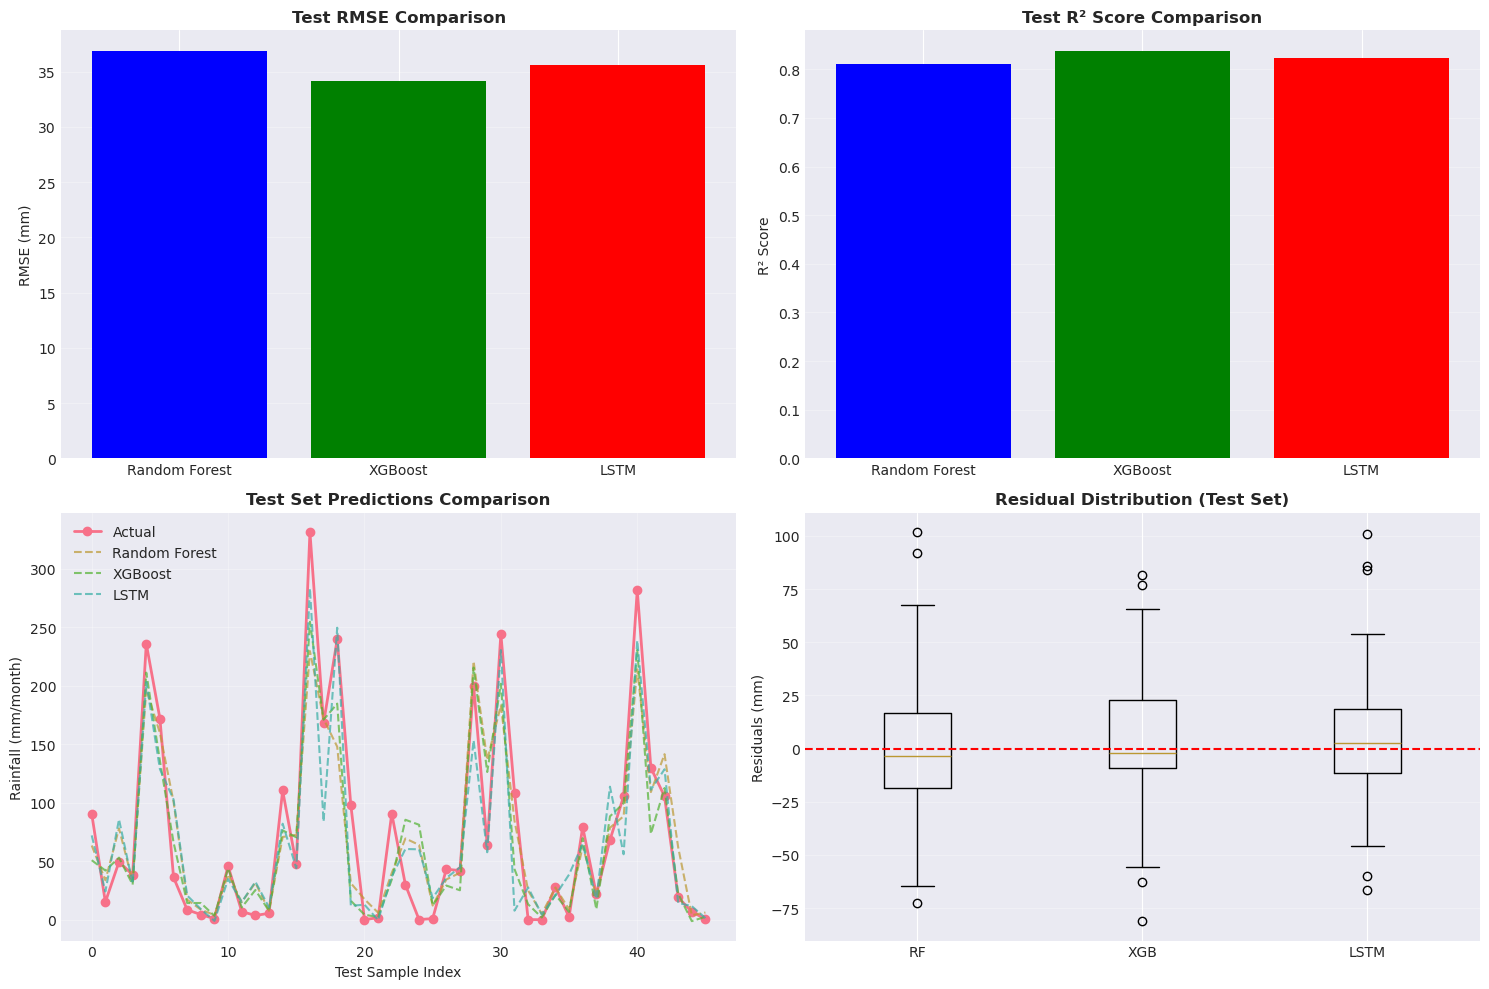

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(model_comparison['Model'], model_comparison['Test RMSE'], color=['blue', 'green', 'red'])
axes[0, 0].set_title('Test RMSE Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE (mm)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar(model_comparison['Model'], model_comparison['Test R²'], color=['blue', 'green', 'red'])
axes[0, 1].set_title('Test R² Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')

test_indices = np.arange(len(y_test))
axes[1, 0].plot(test_indices, y_test, label='Actual', marker='o', linestyle='-', linewidth=2)
axes[1, 0].plot(test_indices, rf_pred_test, label='Random Forest', linestyle='--', alpha=0.7)
axes[1, 0].plot(test_indices, xgb_pred_test, label='XGBoost', linestyle='--', alpha=0.7)
axes[1, 0].plot(test_indices, lstm_pred_test, label='LSTM', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Test Set Predictions Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Test Sample Index')
axes[1, 0].set_ylabel('Rainfall (mm/month)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_rf = y_test - rf_pred_test
residuals_xgb = y_test - xgb_pred_test
residuals_lstm = y_test - lstm_pred_test

axes[1, 1].boxplot([residuals_rf, residuals_xgb, residuals_lstm], labels=['RF', 'XGB', 'LSTM'])
axes[1, 1].set_title('Residual Distribution (Test Set)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuals (mm)')
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '04_model_comparison.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {results_dir}/04_model_comparison.png")
plt.show()

## 11. Summary & Save All Results

In [17]:
annual_rainfall.to_csv(os.path.join(results_dir, 'annual_rainfall.csv'), header=['Rainfall (mm/year)'])
seasonal_summary = seasonal_data.groupby('season')['precipitation_mmmonth'].agg(['mean', 'std', 'min', 'max'])
seasonal_summary.to_csv(os.path.join(results_dir, 'seasonal_summary.csv'))

annual_rainfall.to_pickle(os.path.join(data_dir, 'annual_rainfall.pkl'))
seasonal_summary.to_pickle(os.path.join(data_dir, 'seasonal_summary.pkl'))

print(f"\n{'='*70}")
print(f"ALL RESULTS SAVED TO: {results_dir}/")
print(f"ALL DATA CACHED TO: {data_dir}/")
print(f"{'='*70}")
print(f"\nResults Files:")
for file in sorted(os.listdir(results_dir)):
    file_path = os.path.join(results_dir, file)
    file_size = os.path.getsize(file_path) / 1024
    print(f"  ✓ {file} ({file_size:.1f} KB)")

print(f"\nCached Data Files:")
for file in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, file)
    file_size = os.path.getsize(file_path) / 1024
    print(f"  ✓ {file} ({file_size:.1f} KB)")

print(f"\nTotal result files: {len(os.listdir(results_dir))}")
print(f"Total data cache files: {len(os.listdir(data_dir))}")


ALL RESULTS SAVED TO: results/
ALL DATA CACHED TO: data/

Results Files:
  ✓ 01_exploratory_analysis.png (706.1 KB)
  ✓ 02_seasonal_trends.png (631.5 KB)
  ✓ 03_coefficient_variation.png (215.5 KB)
  ✓ 04_model_comparison.png (616.3 KB)
  ✓ 05_future_forecast.png (387.2 KB)
  ✓ annual_rainfall.csv (0.5 KB)
  ✓ future_rainfall_forecast.csv (0.7 KB)
  ✓ model_comparison.csv (0.3 KB)
  ✓ rainfall_data_raw.csv (15.3 KB)
  ✓ seasonal_summary.csv (0.4 KB)
  ✓ trend_analysis_monthly.csv (1.6 KB)
  ✓ variability_analysis.csv (0.8 KB)

Cached Data Files:
  ✓ annual_rainfall.pkl (1.1 KB)
  ✓ cv_df.pkl (1.3 KB)
  ✓ ml_data.pkl (14.5 KB)
  ✓ model_comparison.pkl (0.9 KB)
  ✓ rainfall_df_cached.pkl (12.6 KB)
  ✓ rainfall_df_processed.pkl (14.0 KB)
  ✓ seasonal_data.pkl (2.3 KB)
  ✓ seasonal_summary.pkl (0.9 KB)
  ✓ trend_df.pkl (1.7 KB)

Total result files: 12
Total data cache files: 9


# 12. Extras

FUTURE RAINFALL PREDICTION FOR DELHI NCR

Generating 12-month ahead forecasts...

Month 01 | Ensemble: 115.26 mm | High Rainfall
Month 02 | Ensemble: 140.86 mm | High Rainfall
Month 03 | Ensemble: 165.19 mm | High Rainfall
Month 04 | Ensemble: 150.15 mm | High Rainfall
Month 05 | Ensemble: 160.24 mm | High Rainfall
Month 06 | Ensemble: 164.18 mm | High Rainfall
Month 07 | Ensemble: 166.61 mm | High Rainfall
Month 08 | Ensemble: 154.63 mm | High Rainfall
Month 09 | Ensemble: 143.60 mm | High Rainfall
Month 10 | Ensemble: 131.08 mm | High Rainfall
Month 11 | Ensemble: 125.19 mm | High Rainfall
Month 12 | Ensemble:  82.04 mm | Moderate Rainfall

Forecast Summary:
  Month  LSTM_Forecast (mm)  XGBoost_Forecast (mm)  RF_Forecast (mm)  Ensemble_Forecast (mm) Forecast_Category
2024-01            4.090000             143.990005            197.69                  115.26     High Rainfall
2024-02           32.910000             197.139999            192.52                  140.86     High Rainfal

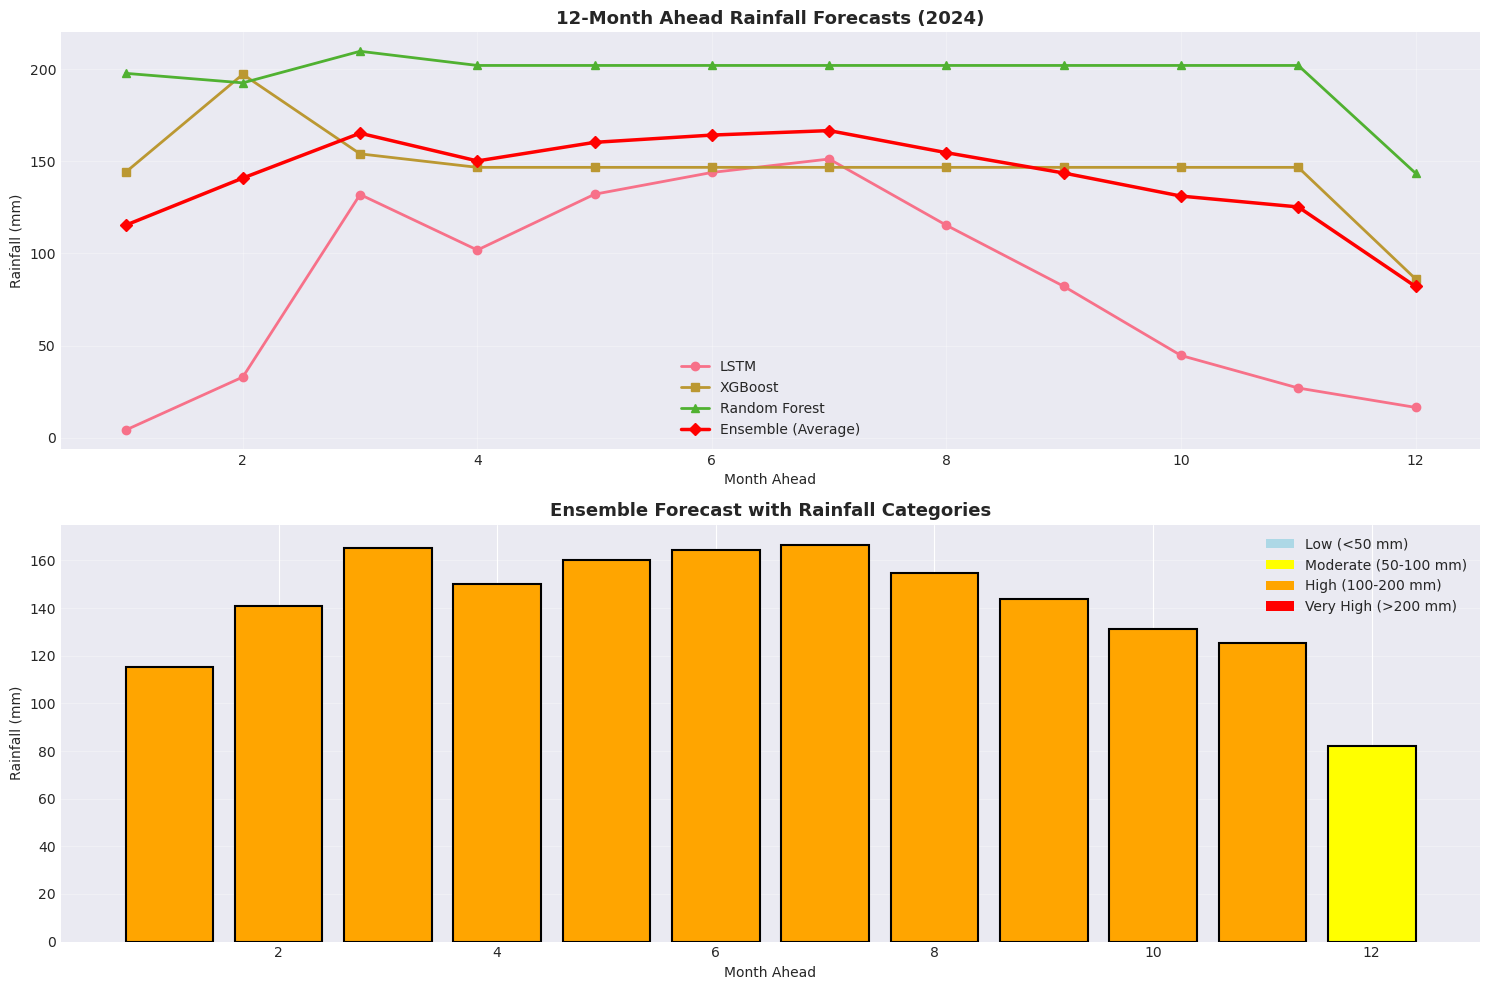


ACTIONABLE INSIGHTS FROM FORECAST:

⚠️  HIGH RAINFALL ALERT:
   2024-03: 165.19 mm — Prepare for potential flooding/waterlogging
   2024-04: 150.15 mm — Prepare for potential flooding/waterlogging
   2024-05: 160.24 mm — Prepare for potential flooding/waterlogging
   2024-06: 164.18 mm — Prepare for potential flooding/waterlogging
   2024-07: 166.61 mm — Prepare for potential flooding/waterlogging
   2024-08: 154.63 mm — Prepare for potential flooding/waterlogging

Average Forecasted Rainfall: 141.59 mm/month over next 12 months
Total Expected Rainfall: 1699.03 mm


In [19]:
# Future Rainfall Prediction (December 2024 onwards)

print("="*70)
print("FUTURE RAINFALL PREDICTION FOR DELHI NCR")
print("="*70)

months_to_predict = 12

future_predictions = {
    'Month': [],
    'LSTM_Forecast (mm)': [],
    'XGBoost_Forecast (mm)': [],
    'RF_Forecast (mm)': [],
    'Ensemble_Forecast (mm)': [],
    'Forecast_Category': []
}

last_rainfall_values = df_ml['precipitation_mmmonth'].tail(12).values.tolist()

print(f"\nGenerating {months_to_predict}-month ahead forecasts...\n")

for pred_month in range(1, months_to_predict + 1):
    
    month_of_year = ((2023 + (pred_month - 1) // 12) * 12 + ((pred_month - 1) % 12) + 12) % 12
    if month_of_year == 0:
        month_of_year = 12
    
    lag_1 = last_rainfall_values[-1]
    lag_3 = last_rainfall_values[-3] if len(last_rainfall_values) >= 3 else np.mean(last_rainfall_values)
    lag_6 = last_rainfall_values[-6] if len(last_rainfall_values) >= 6 else np.mean(last_rainfall_values)
    lag_12 = last_rainfall_values[-12] if len(last_rainfall_values) >= 12 else np.mean(last_rainfall_values)
    
    rolling_mean_3 = np.mean(last_rainfall_values[-3:])
    rolling_mean_6 = np.mean(last_rainfall_values[-6:])
    
    features = np.array([[month_of_year, lag_1, lag_3, lag_6, lag_12, rolling_mean_3, rolling_mean_6]])
    features_scaled = scaler.transform(features)
    
    lstm_features = features_scaled.reshape((1, 1, features_scaled.shape[1]))
    
    lstm_pred = scaler_y.inverse_transform(lstm_model.predict(lstm_features, verbose=0)).flatten()[0]
    xgb_pred = xgb_model.predict(features)[0]
    rf_pred = rf_model.predict(features)[0]
    
    ensemble_pred = (lstm_pred + xgb_pred + rf_pred) / 3
    
    if ensemble_pred < 50:
        category = 'Low Rainfall'
    elif ensemble_pred < 100:
        category = 'Moderate Rainfall'
    elif ensemble_pred < 200:
        category = 'High Rainfall'
    else:
        category = 'Very High Rainfall'
    
    future_predictions['Month'].append(f"2024-{pred_month:02d}")
    future_predictions['LSTM_Forecast (mm)'].append(round(lstm_pred, 2))
    future_predictions['XGBoost_Forecast (mm)'].append(round(xgb_pred, 2))
    future_predictions['RF_Forecast (mm)'].append(round(rf_pred, 2))
    future_predictions['Ensemble_Forecast (mm)'].append(round(ensemble_pred, 2))
    future_predictions['Forecast_Category'].append(category)
    
    last_rainfall_values.append(ensemble_pred)
    if len(last_rainfall_values) > 12:
        last_rainfall_values.pop(0)
    
    print(f"Month {pred_month:02d} | Ensemble: {ensemble_pred:6.2f} mm | {category}")

future_df = pd.DataFrame(future_predictions)
print(f"\n{'='*70}")
print("Forecast Summary:")
print(future_df.to_string(index=False))

future_df.to_csv(os.path.join(results_dir, 'future_rainfall_forecast.csv'), index=False)
future_df.to_pickle(os.path.join(data_dir, 'future_forecast.pkl'))
print(f"\nForecast saved to {results_dir}/future_rainfall_forecast.csv")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

months_plot = range(1, months_to_predict + 1)
axes[0].plot(months_plot, future_predictions['LSTM_Forecast (mm)'], marker='o', label='LSTM', linewidth=2)
axes[0].plot(months_plot, future_predictions['XGBoost_Forecast (mm)'], marker='s', label='XGBoost', linewidth=2)
axes[0].plot(months_plot, future_predictions['RF_Forecast (mm)'], marker='^', label='Random Forest', linewidth=2)
axes[0].plot(months_plot, future_predictions['Ensemble_Forecast (mm)'], marker='D', label='Ensemble (Average)', linewidth=2.5, color='red')
axes[0].set_title('12-Month Ahead Rainfall Forecasts (2024)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Month Ahead')
axes[0].set_ylabel('Rainfall (mm)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

colors_map = {'Low Rainfall': 'lightblue', 'Moderate Rainfall': 'yellow', 'High Rainfall': 'orange', 'Very High Rainfall': 'red'}
colors = [colors_map[cat] for cat in future_predictions['Forecast_Category']]
axes[1].bar(months_plot, future_predictions['Ensemble_Forecast (mm)'], color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Ensemble Forecast with Rainfall Categories', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Month Ahead')
axes[1].set_ylabel('Rainfall (mm)')
axes[1].grid(True, alpha=0.3, axis='y')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Low (<50 mm)'),
                   Patch(facecolor='yellow', label='Moderate (50-100 mm)'),
                   Patch(facecolor='orange', label='High (100-200 mm)'),
                   Patch(facecolor='red', label='Very High (>200 mm)')]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '05_future_forecast.png'), dpi=300, bbox_inches='tight')
print(f"Forecast visualization saved to {results_dir}/05_future_forecast.png")
plt.show()

print(f"\n{'='*70}")
print("ACTIONABLE INSIGHTS FROM FORECAST:")
print(f"{'='*70}")

high_rainfall_months = future_df[future_df['Ensemble_Forecast (mm)'] > 150]
low_rainfall_months = future_df[future_df['Ensemble_Forecast (mm)'] < 50]

if len(high_rainfall_months) > 0:
    print(f"\n⚠️  HIGH RAINFALL ALERT:")
    for idx, row in high_rainfall_months.iterrows():
        print(f"   {row['Month']}: {row['Ensemble_Forecast (mm)']} mm — Prepare for potential flooding/waterlogging")

if len(low_rainfall_months) > 0:
    print(f"\n⚠️  DROUGHT ALERT:")
    for idx, row in low_rainfall_months.iterrows():
        print(f"   {row['Month']}: {row['Ensemble_Forecast (mm)']} mm — Plan water conservation/supplementary irrigation")

avg_forecast = future_df['Ensemble_Forecast (mm)'].mean()
print(f"\nAverage Forecasted Rainfall: {avg_forecast:.2f} mm/month over next 12 months")
print(f"Total Expected Rainfall: {future_df['Ensemble_Forecast (mm)'].sum():.2f} mm")
